In [1]:
install.packages("fmsb")

package 'fmsb' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\IME1\AppData\Local\Temp\RtmpAhHodT\downloaded_packages


In [2]:
install.packages("doMC",repos="https://R-Forge.R-project.org")

installing the source package 'doMC'



.

In [1]:
library(IRdisplay)
library(fmsb)
library(jsonlite)
library(caret)
library(doMC)
source("data_manipulation.r.ipynb")
source("radar_chart.r.ipynb")

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


팀별 데이터준비

In [2]:
teams = c('ds', 'ss', 'nx', 'nc', 'lg', 'sk', 'lt', 'kia', 'hh')
for (team in teams) {
    assign(paste(team,'df_batters', sep=''), read_csv(paste('./data/', team, '_batters.csv', sep=''), remove_below=90))
    assign(paste(team,'df_pitchers', sep=''), read_csv(paste('./data/', team, '_pitchers.csv', sep=''), remove_below=0))
}

In [3]:
alldf_batters = list()
alldf_pitchers = list()
for (team in teams) {
    alldf_batters = c(alldf_batters, list(get(paste(team, 'df_batters', sep=''))))
    alldf_pitchers = c(alldf_pitchers, list(get(paste(team, 'df_pitchers', sep=''))))
}

In [4]:
alldf_batters_norm = normalize_whole(alldf_batters, is_pitchers = FALSE)
alldf_pitchers_norm = normalize_whole(alldf_pitchers, is_pitchers = TRUE)

In [5]:

all_team_norm = list()
ptr = 1
for (name in teams) {
    all_team_norm[[name]] = list('batters'=alldf_batters_norm[[ptr]],
                                 'pitchers'=alldf_pitchers_norm[[ptr]])
    ptr = ptr + 1
}

In [6]:
WDL = fromJSON('data/WDL3.json')

In [7]:

top4 = data.frame(
    'OBP'= c(0.60, 0),
    'SLG'= c(0.60, 0),
    'AVG'= c(0.60, 0),
    'WHIP'= c(0.60, 0),
    'QS'= c(0.60, 0),
    'FIP'= c(0.60, 0),
    'SAVE'=c(0.60, 0)
)

top4 = rbind(top4, get_radarchart_row(all_team_norm[['ds']][['batters']], all_team_norm[['ds']][['pitchers']]))
top4 = rbind(top4, get_radarchart_row(all_team_norm[['ss']][['batters']], all_team_norm[['ss']][['pitchers']]))
top4 = rbind(top4, get_radarchart_row(all_team_norm[['nc']][['batters']], all_team_norm[['nc']][['pitchers']]))
top4 = rbind(top4, get_radarchart_row(all_team_norm[['nx']][['batters']], all_team_norm[['nx']][['pitchers']]))

In [8]:
wprobdf = list(
    'Probability'=c()
)

In [9]:
for (own in teams) {
    owndf = get_radarchart_row(all_team_norm[[own]][['batters']], all_team_norm[[own]][['pitchers']])
    for (opp in teams) {
        if (own != opp) {
            oppdf = get_radarchart_row(all_team_norm[[opp]][['batters']], all_team_norm[[opp]][['pitchers']])
            W = WDL[[own]][[opp]][['W']]
            L = WDL[[own]][[opp]][['L']]
            D = WDL[[own]][[opp]][['D']]
            T = W + D + L
            
            for (column in names(owndf)) {
                owncol = paste(column, 'own', sep='')
                oppcol = paste(column, 'opp', sep='')
                wprobdf[[owncol]] = c(wprobdf[[owncol]], owndf[[column]])
                wprobdf[[oppcol]] = c(wprobdf[[oppcol]], oppdf[[column]])
            }
            
            wprobdf[['Probability']] = c(wprobdf[['Probability']], W / T)
        }
    }
}

In [10]:
wprobdf = data.frame(wprobdf)

In [11]:
wmodel = lm(Probability ~ ., data=wprobdf)

In [12]:
summary(wmodel)


Call:
lm(formula = Probability ~ ., data = wprobdf)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.232052 -0.091793 -0.004838  0.096106  0.243330 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.02631    1.31487   0.020 0.984104    
OBPown      -1.96131    0.77190  -2.541 0.013805 *  
OBPopp       2.74899    0.77190   3.561 0.000753 ***
SLGown      -1.28704    1.07632  -1.196 0.236734    
SLGopp       2.24811    1.07632   2.089 0.041212 *  
AVGown       4.63694    2.17926   2.128 0.037695 *  
AVGopp      -6.78348    2.17926  -3.113 0.002897 ** 
WHIPown     -3.05941    1.88453  -1.623 0.110014    
WHIPopp      3.64501    1.88453   1.934 0.058061 .  
QSown        0.30571    0.54308   0.563 0.575694    
QSopp       -0.61957    0.54308  -1.141 0.258706    
FIPown      -1.97470    1.53423  -1.287 0.203263    
FIPopp       3.24748    1.53423   2.117 0.038665 *  
SAVEown      0.22360    0.13240   1.689 0.096716 .  
SAVEopp     -0.30302   

In [13]:
wprob_pca = prcomp(wprobdf[,!(names(wprobdf) == c('Probability'))], center=TRUE, scale=TRUE)
summary(wprob_pca)

Importance of components:
                         PC1    PC2    PC3    PC4    PC5     PC6     PC7
Standard deviation     2.080 1.8344 1.3553 1.1953 0.9685 0.85417 0.76441
Proportion of Variance 0.309 0.2404 0.1312 0.1021 0.0670 0.05211 0.04174
Cumulative Proportion  0.309 0.5494 0.6806 0.7827 0.8497 0.90178 0.94352
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.67415 0.34148 0.30115 0.26126 0.23041 0.06535 0.05764
Proportion of Variance 0.03246 0.00833 0.00648 0.00488 0.00379 0.00031 0.00024
Cumulative Proportion  0.97598 0.98431 0.99079 0.99567 0.99946 0.99976 1.00000

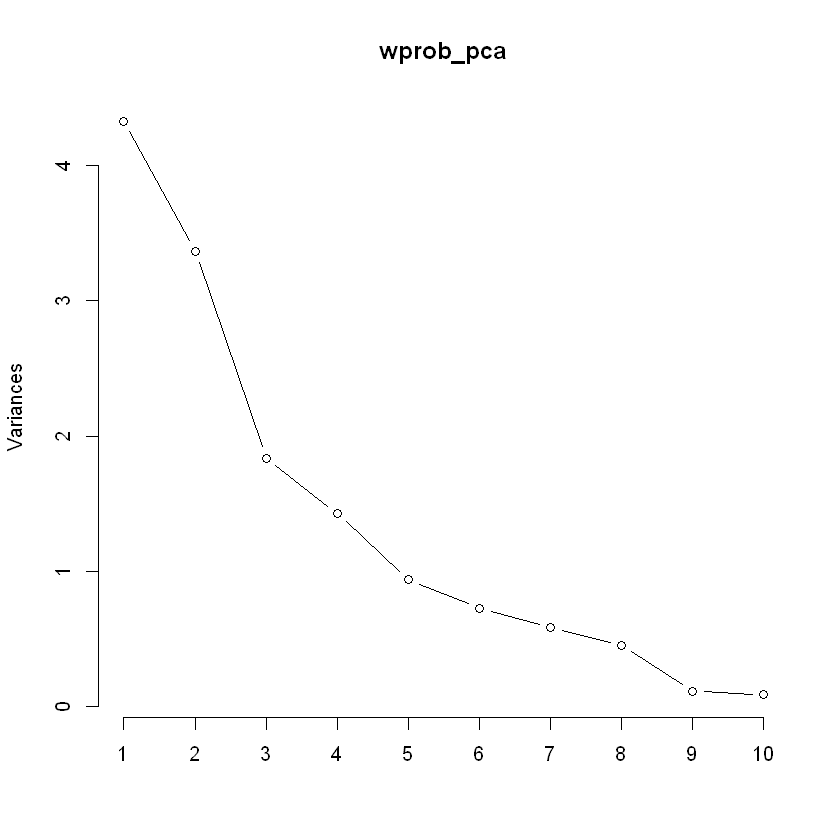

In [14]:
plot(wprob_pca, type = "l")

그래서 CP(cumulative proportion)이 0.85가 되는 PC5 까지 사용하기로 함.

In [15]:
wprob5d = data.frame(predict(wprob_pca, wprobdf)[, 1:5])
wprob5d$Probability = wprobdf$Probability

In [16]:
wmodel = lm(Probability ~ ., data=wprob5d)
summary(wmodel)


Call:
lm(formula = Probability ~ ., data = wprob5d)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31859 -0.10807  0.00586  0.09300  0.33012 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.4913194  0.0168974  29.077  < 2e-16 ***
PC1         -0.0294837  0.0081806  -3.604 0.000602 ***
PC2         -0.0002923  0.0092759  -0.032 0.974954    
PC3         -0.0134593  0.0125551  -1.072 0.287615    
PC4          0.0039644  0.0142361   0.278 0.781519    
PC5          0.0051156  0.0175688   0.291 0.771828    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1434 on 66 degrees of freedom
Multiple R-squared:  0.1781,	Adjusted R-squared:  0.1158 
F-statistic:  2.86 on 5 and 66 DF,  p-value: 0.0213


R-squared 값이 작아 다른 방법 시도

## Neural Network 

In [17]:
wprob5d$X1 = wprob5d$PC1*wprob5d$PC1
wprob5d$X2 = wprob5d$PC1*wprob5d$PC2
wprob5d$X3 = wprob5d$PC1*wprob5d$PC3
wprob5d$X4 = wprob5d$PC1*wprob5d$PC4
wprob5d$X5 = wprob5d$PC1*wprob5d$PC5
wprob5d$X6 = wprob5d$PC2*wprob5d$PC3
wprob5d$X7 = wprob5d$PC2*wprob5d$PC4
wprob5d$X8 = wprob5d$PC2*wprob5d$PC5

wprob5d$Y1 = wprob5d$PC1/wprob5d$PC2
wprob5d$Y2 = wprob5d$PC1/wprob5d$PC3
wprob5d$Y3 = wprob5d$PC1/wprob5d$PC4
wprob5d$Y4 = wprob5d$PC1/wprob5d$PC5
wprob5d$Y5 = wprob5d$PC2/wprob5d$PC1
wprob5d$Y6 = wprob5d$PC2/wprob5d$PC3
wprob5d$Y7 = wprob5d$PC2/wprob5d$PC4
wprob5d$Y8 = wprob5d$PC2/wprob5d$PC5

wprob5d$Z2 = wprob5d$PC2*wprob5d$PC2
wprob5d$Z3 = wprob5d$PC3*wprob5d$PC3
wprob5d$Z4 = wprob5d$PC4*wprob5d$PC4
wprob5d$Z5 = wprob5d$PC5*wprob5d$PC5

wprob5d$W1 = wprob5d$X1*wprob5d$PC1
wprob5d$W2 = wprob5d$X1*wprob5d$PC2
wprob5d$W3 = wprob5d$X1*wprob5d$PC3
wprob5d$W4 = wprob5d$X1*wprob5d$PC4
wprob5d$W5 = wprob5d$X1*wprob5d$PC5
wprob5d$W6 = wprob5d$X2*wprob5d$PC3
wprob5d$W7 = wprob5d$X2*wprob5d$PC4
wprob5d$W8 = wprob5d$X2*wprob5d$PC5

In [18]:
install.packages("RSNNS")

package 'RSNNS' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'RSNNS'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"C:\Users\IME1\anaconda3\envs\kbo\Lib\R\library\00LOCK\RSNNS\libs\x64\RSNNS.dll를 C:\Users\IME1\anaconda3\envs\kbo\Lib\R\library\RSNNS\libs\x64\RSNNS.dll로 복사하는데 문제가 발생했습니다: Permission denied"Warning message:
"restored 'RSNNS'"


The downloaded binary packages are in
	C:\Users\IME1\AppData\Local\Temp\Rtmp2V2BhF\downloaded_packages


In [19]:
fit.control <- trainControl(## 10-fold CV
                           method = 'repeatedcv',
                           number = 10,
                           ## repeated ten times
                           repeats = 10)
set.seed(4335)
# registerDoMC(cores = 6)
wmodel <- train(Probability ~ PC1+PC2+PC3+PC4+PC5+
                              W1+W2+W3+W4+W5+W6+W7+W8+
                              X1+X2+X3+X4+X5+X6+X7+X8+
                              Y1+Y2+Y3+Y4+Y5+Y6+Y7+Y8+
                              Z2+Z3+Z4+Z5,
                data=wprob5d,
                method = 'mlpWeightDecay',
                trControl = fit.control)

Warning message in load(system.file("models", "models.RData", package = "caret")):
"strings not representable in native encoding will be translated to UTF-8"

In [20]:
save(wmodel, file="winningprob1.RData")

In [21]:
load("winningprob1.RData")

In [22]:
cor(predict(wmodel, wprob5d[-6]), wprob5d$Probability)

[1] 0.9406982

In [23]:
prepare = function(df) {
    df$X1 = df$PC1*df$PC1
    df$X2 = df$PC1*df$PC2
    df$X3 = df$PC1*df$PC3
    df$X4 = df$PC1*df$PC4
    df$X5 = df$PC1*df$PC5
    df$X6 = df$PC2*df$PC3
    df$X7 = df$PC2*df$PC4
    df$X8 = df$PC2*df$PC5

    df$Y1 = df$PC1/df$PC2
    df$Y2 = df$PC1/df$PC3
    df$Y3 = df$PC1/df$PC4
    df$Y4 = df$PC1/df$PC5
    df$Y5 = df$PC2/df$PC1
    df$Y6 = df$PC2/df$PC3
    df$Y7 = df$PC2/df$PC4
    df$Y8 = df$PC2/df$PC5

    df$Z2 = df$PC2*df$PC2
    df$Z3 = df$PC3*df$PC3
    df$Z4 = df$PC4*df$PC4
    df$Z5 = df$PC5*df$PC5

    df$W1 = df$X1*df$PC1
    df$W2 = df$X1*df$PC2
    df$W3 = df$X1*df$PC3
    df$W4 = df$X1*df$PC4
    df$W5 = df$X1*df$PC5
    df$W6 = df$X2*df$PC3
    df$W7 = df$X2*df$PC4
    df$W8 = df$X2*df$PC5
    
    return(df)
}

In [24]:
predict_result = function(owndf, oppdf, verbose=TRUE) {
    predict_right = list()
    predict_reverse = list()
    
    for (column in names(owndf)) {
        owncol = paste(column, 'own', sep='')
        oppcol = paste(column, 'opp', sep='')
        predict_right[[owncol]] = c(predict_right[[owncol]], owndf[[column]])
        predict_right[[oppcol]] = c(predict_right[[oppcol]], oppdf[[column]])
        predict_reverse[[owncol]] = c(predict_reverse[[owncol]], oppdf[[column]])
        predict_reverse[[oppcol]] = c(predict_reverse[[oppcol]], owndf[[column]])
    }
    
    predict_right = prepare(data.frame(predict(wprob_pca, data.frame(predict_right)))[, 1:5])
    predict_reverse = prepare(data.frame(predict(wprob_pca, data.frame(predict_reverse)))[, 1:5])
    
    winprob = predict(wmodel, predict_right)
    losprob = predict(wmodel, predict_reverse)
    
    if (verbose) {
        print('--------')
        print(winprob)
        print(losprob)
        print('--------')
    }
    
    if (winprob - losprob > 0.07) {
        return('Win')
    } else if (winprob - losprob < -0.07) {
        return('Lose')
    } else {
        return('Draw')
    }
}

In [25]:
own = 'ds'
opp = 'nc'
print(paste(own, ' vs. ', opp, 'predicted: ',
            predict_result(get_radarchart_row(all_team_norm[[own]][['batters']], all_team_norm[[own]][['pitchers']]),
                           get_radarchart_row(all_team_norm[[opp]][['batters']], all_team_norm[[opp]][['pitchers']])),
      'actual(W/L/D): ',
      toString(WDL[[own]][[opp]][['W']]),'/',toString(WDL[[own]][[opp]][['L']]),'/',toString(WDL[[own]][[opp]][['D']])))

[1] "--------"
        1 
0.4239649 
        1 
0.5962694 
[1] "--------"
[1] "ds  vs.  nc predicted:  Lose actual(W/L/D):  7 / 9 / 0"


In [29]:
own = 'lg'
opp = ''
print(paste(own, ' vs. ', opp, 'predicted: ',
            predict_result(get_radarchart_row(all_team_norm[[own]][['batters']], all_team_norm[[own]][['pitchers']]),
                           get_radarchart_row(all_team_norm[[opp]][['batters']], all_team_norm[[opp]][['pitchers']])),
      'actual(W/L/D): ',
      toString(WDL[[own]][[opp]][['W']]),'/',toString(WDL[[own]][[opp]][['L']]),'/',toString(WDL[[own]][[opp]][['D']])))

[1] "--------"
        1 
0.6609514 
        1 
0.3302851 
[1] "--------"
[1] "lg  vs.  ds predicted:  Win actual(W/L/D):  11 / 5 / 0"


In [30]:
own = 'ds'
opp = 'kia'
print(paste(own, ' vs. ', opp, 'predicted: ',
            predict_result(get_radarchart_row(all_team_norm[[own]][['batters']], all_team_norm[[own]][['pitchers']]),
                           get_radarchart_row(all_team_norm[[opp]][['batters']], all_team_norm[[opp]][['pitchers']])),
      'actual(W/L/D): ',
      toString(WDL[[own]][[opp]][['W']]),'/',toString(WDL[[own]][[opp]][['L']]),'/',toString(WDL[[own]][[opp]][['D']])))

[1] "--------"
        1 
0.5717806 
       1 
0.400052 
[1] "--------"
[1] "ds  vs.  kia predicted:  Win actual(W/L/D):  10 / 6 / 0"


In [31]:
install.packages("NeuralNetTools")

package 'NeuralNetTools' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\IME1\AppData\Local\Temp\Rtmp2V2BhF\downloaded_packages


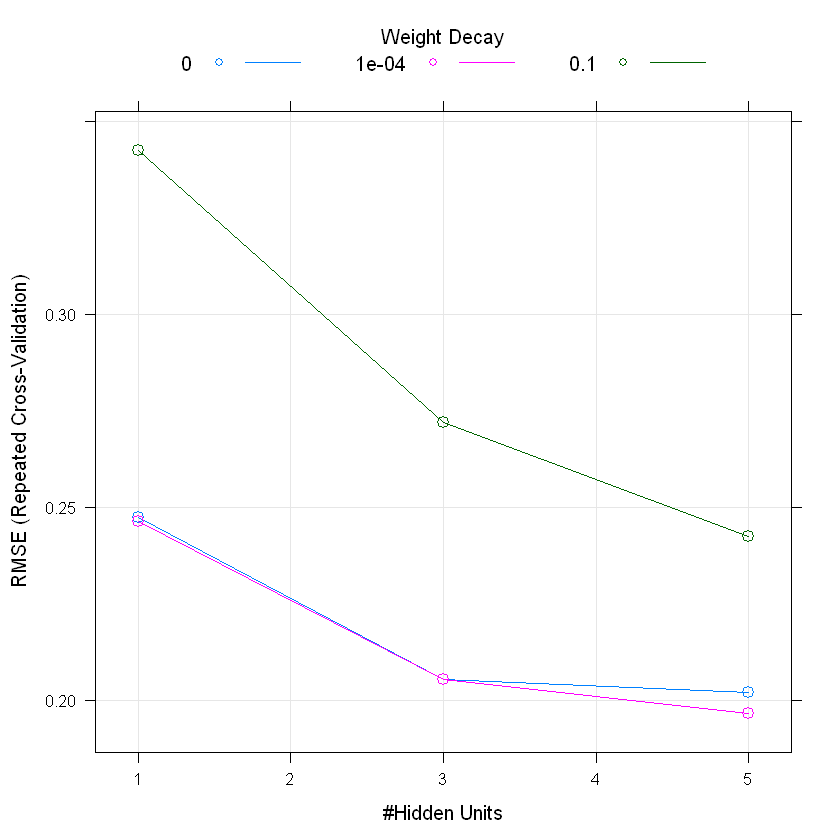

In [35]:
plot(wmodel, rep = NULL, wmodel.entry = NULL, wmodel.out = NULL,
  radius = 0.15, arrow.length = 0.2, intercept = TRUE,
  intercept.factor = 0.4, information = TRUE, information.pos = 0.1,
  col.entry.synapse = "black", col.entry = "black",
  col.hidden = "black", col.hidden.synapse = "black",
  col.out = "black", col.out.synapse = "black",
  col.intercept = "blue", fontsize = 12, dimension = 6,
  show.weights = TRUE, file = NULL)